# Cifar Library and Demo

This is a library to download and parse the Cifar datasets (Cifar-10 and Cifar-100), and a very small demo of a FNN (Feedforward Neural Network) with GoMLX. FNNs are notoriously bad for images, but it's only a demo. Look for the Resnet50 model for a more serious image classification model (old but still good -- best results as of the time of this writing is with ViT model).

The CIFAR-10 and CIFAR-100 are labeled subsets of the 80 million tiny images dataset. They were collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton. See more details in [its homepage here](https://www.cs.toronto.edu/~kriz/cifar.html).

In [1]:
!*go mod edit -replace gomlx=/home/janpf/Projects/gomlx

## Data Preparation

### Downloading data files

To download, uncompress and untar to the local directory, simply do the following. Notice if it's already downloaded in the given `--data` directory, it returns immediately.

In [2]:
import (
    "github.com/gomlx/gomlx/examples/cifar"
    "github.com/gomlx/gomlx/ml/data"
)

var flagDataDir = flag.String("data", "~/tmp/cifar", "Directory to cache downloaded and generated dataset files.")

func AssertNoError(err error) {
    if err != nil {
        log.Fatalf("Failed: %+v", err)
    }
}

func AssertDownloaded() {
    *flagDataDir = data.ReplaceTildeInDir(*flagDataDir)
    if !data.FileExists(*flagDataDir) {
        AssertNoError(os.MkdirAll(*flagDataDir, 0777))
    }

    AssertNoError(cifar.DownloadCifar10(*flagDataDir))
    AssertNoError(cifar.DownloadCifar100(*flagDataDir))
}

%%
AssertDownloaded()

In [3]:
!ls -lh ~/tmp/cifar/

total 323M
drwxr-xr-x 2 janpf janpf 4.0K Feb 20  2010 cifar-100-binary
-rw-r--r-- 1 janpf janpf 161M Mar 16 07:57 cifar-100-binary.tar.gz
drwxr-xr-x 2 janpf janpf 4.0K Jun  4  2009 cifar-10-batches-bin
-rw-r--r-- 1 janpf janpf 163M Mar 16 07:57 cifar-10-binary.tar.gz


### Sample some images

The `cifar.LoadCifar10` and `cifar.LoadCifar100` funcitons load the whole dataset into a `tensor.Tensor`. Here we sample and display a few of each, to check things are working.


Example 24135: cat (3),Example 23222: bird (2),Example 30898: truck (9),Example 36528: dog (5)
Example 3629: bird (2),Example 34008: dog (5),Example 42890: truck (9),Example 18786: truck (9)

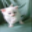
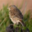
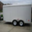
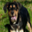
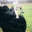
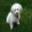
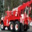
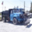

Example 43201: beetle (7),Example 45622: couch (25),Example 43292: worm (99),Example 12533: mouse (50)
Example 9226: beetle (7),Example 41659: couch (25),Example 10387: turtle (93),Example 14158: house (37)

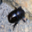
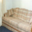
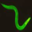
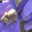
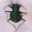
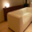
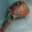
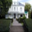

In [4]:
import (
    "github.com/gomlx/gomlx/examples/cifar"
    "github.com/gomlx/gomlx/types/shapes"

    "github.com/janpfeifer/gonb/gonbui"
)

// sampleToNotebook generates a sample of Cifar-10 and Cifar-100 in a GoNB Jupyter Notebook.
func sampleToNotebook(rows, cols int) {
    dtype := shapes.Float32
    
    // Load data into tensors.
    images10, labels10, err := cifar.LoadCifar10(*flagDataDir, dtype)
    AssertNoError(err)
    images100, labels100, err := cifar.LoadCifar100(*flagDataDir, dtype)
    AssertNoError(err)
    
    sampleTable("Samples from Cifar-10", images10.Local(), labels10.Local(), cifar.C10Labels[:], rows, cols)
    sampleTable("Samples from Cifar-100", images100.Local(), labels100.Local(), cifar.C100FineLabels[:], rows, cols)
}

// sampleTable generates and outputs one html table of samples, sampling rows x cols from the images/labels provided.
func sampleTable(title string, images, labels *tensor.Local, labelsText []string, rows, cols int) {
    htmlRows := make([]string, 0, rows)
    for row := 0; row < rows; row++ {
        cells := make([]string, 0, cols)
        for col := 0; col < cols; col++ {
            cells = append(cells, sampleOneImage(images, labels, labelsText))
        }
        htmlRows = append(htmlRows, fmt.Sprintf("<tr>\n\t<td>%s</td>\n</tr>", strings.Join(cells, "</td>\n\t<td>")))
    }
    htmlTable := fmt.Sprintf("<h3>%s</h3><table>%s</table>\n", title, strings.Join(htmlRows, ""))
    gonbui.DisplayHTML(htmlTable)
}

// sampleOneImage one image from tensor and returns an HTML rendered image with label
func sampleOneImage(images, labels *tensor.Local, labelsText []string) string {
    exampleNum := rand.Intn(images.Shape().Dimensions[0])
    labelsData := tensor.Data[int](labels)
    label := labelsData[exampleNum]
    labelStr := labelsText[label]
    img := cifar.ConvertToGoImage(images, exampleNum)
    imgSrc, err := gonbui.EmbedImageAsPNGSrc(img)
    AssertNoError(err)
    return fmt.Sprintf(`<figure style="padding:4px;text-align: center;"><img width="128" height="128" src="%s"><figcaption style="text-align: center;">Example %d: %s (%d)</figcaption></figure>`, imgSrc, exampleNum, labelStr, label)
}

%%
AssertDownloaded()
rows, cols := 2, 4
sampleToNotebook(rows, cols)

## Training on Cifar-10

### Models Support

In this cell we define 3 functions we are going to use for the modeling:

1. `getBatchedImages`: this will take the `cifar.Dataset` yielded `spec`, and convert the image indices that are given as input, and convert them to the actual batch of images. The whole Cifar-10 dataset is configured as a variable -- so it can be stored in the accelerator memory for faster access. This function will call the `Dataset.GatherImagesGraph` to retrieve it.
1. `normalizeImage` and `normalizeFeatures`: they normalize `x` according to the hyperparameter given in `flagNormalization` flag.


In [5]:
import (
    "flags"
    
    . "github.com/gomlx/gomlx/graph"
    "github.com/gomlx/gomlx/examples/cifar"
    "github.com/gomlx/gomlx/ml/context"
)

var (
    // ML Manager creation:
    flagNumThreads  = flag.Int("num_threads", -1, "Number of threads. Leave as -1 to use as many as there are cores.")
    flagNumReplicas = flag.Int("num_replicas", 1, "Number of replicas.")
    flagPlatform    = flag.String("platform", "", "Platform to use, if empty uses the default one.")

    // Model hyper-parameters.
    flagL2Regularization = flag.Float64("l2_reg", 0, "L2 regularization on kernels. It doesn't interact well with --batch_norm.")
    flagNormalization    = flag.String("norm", "layer", "Type of normalization to use. Valid values are \"none\", \"batch\", \"layer\".")

    // Model hyperparameters:
    flagNumHiddenLayers = flag.Int("hidden_layers", 8, "Number of hidden layers, stacked with residual connection.")
    flagNumNodes        = flag.Int("num_nodes", 128, "Number of nodes in hidden layers.")
    flagDropoutRate     = flag.Float64("dropout", 0, "Dropout rate")
)

func getBatchedImages(ctx *context.Context, spec any, inputs []*Node) (batchedImages *Node) {
    g := inputs[0].Graph()
    if !g.Ok() {
        return nil
    }

    if spec != nil {
        // spec should hold the dataset that converts the image indices to the actual
        // images, by gathering from a large variable that holds all the images.
        dataset, ok := spec.(*cifar.Dataset)
        if !ok {
            g.SetErrorf("spec given to FNNModelGraph is not a *cifarDataset, instead got %T", spec)
            return nil
        }
        // We assume that batchedImages passed is actually a list of indices, and we need to gather
        // the actual images.
        batchedImages = dataset.GatherImagesGraph(ctx, inputs[0])
    } else {
        // If a spec was not given, we assume the raw images are being fed for inference.
        batchedImages = inputs[0]
    }
    if !batchedImages.Ok() {
        g.SetErrorf("failed to load batch of images")
        return nil
    }
    return
}

func normalizeImage(ctx *context.Context, x *Node) *Node {
    switch *flagNormalization {
    case "layer":
        return layers.LayerNormalization(ctx, x, 1, 2).ScaleNormalization(false).Done()
    case "batch":
        return layers.BatchNormalization(ctx, x, -1).Done()
    case "none":
        return x
    }
    g := x.Graph()
    g.SetErrorf("invalid normalization selected %q -- valid values are batch, layer, none", *flagNormalization)
    return g.InvalidNode()
}

func normalizeFeatures(ctx *context.Context, x *Node) *Node {
    switch *flagNormalization {
    case "layer":
        return layers.LayerNormalization(ctx, x, -1).Done()
    case "batch":
        return layers.BatchNormalization(ctx, x, -1).Done()
    case "none":
        return x
    }
    g := x.Graph()
    g.SetErrorf("invalid normalization selected %q -- valid values are batch, layer, none", *flagNormalization)
    return g.InvalidNode()
}


### Simple FNN model

A trivial model, that can easily get to ~45% accuracy (a random model would do 10%), but hardly much more than that.

Later we are going to define a CNN model to compare, and we just set a placeholder model here for now.

> **Note**: 
>
> * Cifar datasets yields (`Dataset.Yield()`) only the indices to the images of the batch as a `Tensor`. But it provides a `GatherImagesGraph` method that gathers the images from a static variable that holds the whole dataset (~1Gb in memory, stored as float32). We access it through the `getBatchedImatges()` defined above. 


In [6]:
import (
    "flags"
    
    . "github.com/gomlx/gomlx/graph"
    "github.com/gomlx/gomlx/examples/cifar"
    "github.com/gomlx/gomlx/ml/context"
    "github.com/gomlx/gomlx/ml/train/optimizers"
    "github.com/gomlx/gomlx/types/shapes"
)

var DType = shapes.Float32

func FNNModelGraph(ctx *context.Context, spec any, inputs []*Node) []*Node {
    g := inputs[0].Graph()
    if !g.Ok() {
        return nil
    }
    batchedImages := getBatchedImages(ctx, spec, inputs)
    if !g.Ok() {
        return nil
    }
    batchSize := batchedImages.Shape().Dimensions[0]
    logits := Reshape(batchedImages, batchSize, -1)
    {
        ctx := ctx.In("Dense_0")
        logits = layers.DenseWithBias(ctx, logits, *flagNumNodes)
        logits = normalizeFeatures(ctx, logits)
    }
    for ii := 1; ii < *flagNumHiddenLayers; ii++ {
        ctx := ctx.In(fmt.Sprintf("Dense_%d", ii))
        // Add layer with residual connection.
        tmp := Sigmoid(logits)
        if *flagDropoutRate > 0 {
            tmp = layers.Dropout(ctx, tmp, Const(g, shapes.CastAsDType(*flagDropoutRate, tmp.DType())))
        }
        tmp = layers.DenseWithBias(ctx, tmp, *flagNumNodes)
        tmp = normalizeFeatures(ctx, tmp)
        logits = Add(logits, tmp)
    }
    logits = Sigmoid(logits)
    logits = layers.DenseWithBias(ctx.In("denseFinal"), logits, len(cifar.C10Labels))
    return []*Node{logits}
}

// Only a placeholder for now.
func CNNModelGraph(ctx *context.Context, spec any, inputs []*Node) []*Node {
    return nil   
}

%% --platform=Host

// Let's test that the logits are coming out with the right shape: we want [batch_size, 10], since there are 10 classes.
AssertDownloaded()
manager := BuildManager().NumThreads(*flagNumThreads).NumReplicas(*flagNumReplicas).Platform(*flagPlatform).MustDone()
trainDS, err := cifar.NewDataset("Cifar-10 Batched Train", *flagDataDir, cifar.C10, DType, cifar.Train, 3, false) // loops forever.
AssertNoError(err)

graph := manager.NewGraph("test")
ctx := context.NewContext(manager)
logits := FNNModelGraph(ctx, trainDS, []*Node{graph.Parameter("images", shapes.Make(shapes.Int64, /*Batch Size*/ 3, 1))})
AssertNoError(graph.Error())
AssertNoError(ctx.Error())
fmt.Printf("Logits shape for batch_size=%d: %s\n", 3, logits[0].Shape())


Logits shape for batch_size=3: (Float32)[3 10]


### Training Loop

With a model function defined, let's create our training loop, with the usual bells and whistles: accuracy metrics, progress-bar, plot of metrics, checkpoints.

In [7]:
import (
    "flags"
    
    "github.com/gomlx/gomlx/examples/cifar"
    "github.com/gomlx/gomlx/ml/context"
    "github.com/gomlx/gomlx/ml/train"
    "github.com/gomlx/gomlx/types/slices"
)

var (
    // Training flags:
    flagModel            = flag.String("model", "fnn", "Model type: fnn or cnn.")
    flagNumSteps         = flag.Int("steps", 2000, "Number of gradient descent steps to perform")
    flagBatchSize        = flag.Int("batch", 50, "Batch size for training")
    flagOptimizer        = flag.String("optimizer", "adamw", fmt.Sprintf("Optimizer, options: %v", slices.Keys(optimizers.KnownOptimizers)))
    flagLearningRate     = flag.Float64("learning_rate", 0.0001, "Initial learning rate.")
    flagCheckpoint       = flag.String("checkpoint", "", "Directory save and load checkpoints from. If left empty, no checkpoints are created.")
    flagCheckpointKeep   = flag.Int("checkpoint_keep", 10, "Number of checkpoints to keep, if --checkpoint is set.")
    
    // Training UI:
    flagUseProgressBar = flag.Bool("bar", true, "If to display a progress bar during training")
    flagNumPlotPoints  = flag.Int("plot_points", 50, "Number points to plot.")
)

var (
    // DType used for the model.
    DType = shapes.Float32
    
    // EvalBatchSize can be larger than training, more efficient.
    EvalBatchSize = 2000
)


func trainModel() {
    // Make sure data is downloaded.
    AssertDownloaded()

    // Manager handles creation of ML computation graphs, accelerator resources, etc.
    manager := BuildManager().NumThreads(*flagNumThreads).NumReplicas(*flagNumReplicas).Platform(*flagPlatform).MustDone()
    fmt.Printf("Platform: %s\n", manager.Platform())

    // Create datasets used for training and evaluation.
    trainDS, err := cifar.NewDataset("Cifar-10 Batched Train", *flagDataDir, cifar.C10, DType, cifar.Train, *flagBatchSize, false) // loops forever.
    AssertNoError(err)
    evalOnTestDS, err := cifar.NewDataset("Cifar-10 Eval On Test", *flagDataDir, cifar.C10, DType, cifar.Test, EvalBatchSize, true) // 1 epoch.
    AssertNoError(err)
    evalOnTrainDS, err := cifar.NewDataset("Cifar-10 Eval On Train", *flagDataDir, cifar.C10, DType, cifar.Train, EvalBatchSize, true) // 1 epoch.
    AssertNoError(err)

    // Create closure for model graph building function, that uses statically the dataset
    // used for its `cifar.Dataset.GatherImageGraph`, to convert image indices to the actual images.
    // This is the signature of model function that the train.Trainer accepts.
    modelFn := FNNModelGraph
    if *flagModel == "cnn" {
        modelFn = CNNModelGraph
    }

    // Metrics we are interested.
    meanAccuracyMetric := metrics.NewSparseCategoricalAccuracy("Mean Accuracy", "#acc")
    movingAccuracyMetric := metrics.NewMovingAverageSparseCategoricalAccuracy("Moving Average Accuracy", "~acc", 0.01)

    // Context holds the variables and hyperparameters for the model.
    ctx := context.NewContext(manager)
    ctx.SetParam(optimizers.LearningRateKey, *flagLearningRate)
    ctx.SetParam(layers.L2RegularizationKey, *flagL2Regularization)

    // Checkpoints saving.
    var checkpoint *checkpoints.Handler
    if *flagCheckpoint != "" {
        checkpointPath := data.ReplaceTildeInDir(*flagCheckpoint)
        if !path.IsAbs(checkpointPath) {
            checkpointPath = path.Join(*flagDataDir, checkpointPath)
        }
        var err error
        checkpoint, err = checkpoints.Build(ctx).Dir(checkpointPath).Keep(*flagCheckpointKeep).Done()
        AssertNoError(err)
    }

    // Create a train.Trainer: this object will orchestrate running the model, feeding
    // results to the optimizer, evaluating the metrics, etc. (all happens in trainer.TrainStep)
    trainer := train.NewTrainer(manager, ctx, modelFn,
        losses.SparseCategoricalCrossEntropyLogits,
        optimizers.MustOptimizerByName(*flagOptimizer),
        []metrics.Interface{movingAccuracyMetric}, // trainMetrics
        []metrics.Interface{meanAccuracyMetric})   // evalMetrics

    // Use standard training loop.
    loop := train.NewLoop(trainer)
    if *flagUseProgressBar {
        commandline.AttachProgressBar(loop) // Attaches a progress bar to the loop.
    }

    // Attach a checkpoint.
    if checkpoint != nil {
        train.NTimesDuringLoop(loop, *flagCheckpointKeep, "checkpointing", 100, func(_ *train.Loop, _ []tensor.Tensor) error {
            return checkpoint.Save()
        })
    }

    // Attach a margaid plots.
    if *flagNumPlotPoints > 0 {
        margaid.New(1024, 400, evalOnTrainDS, evalOnTestDS).DynamicUpdates().Attach(loop, *flagNumPlotPoints)
    }

    // Loop for given number of steps.
    _, err = loop.RunSteps(trainDS, *flagNumSteps)
    AssertNoError(err)

    // Finally print an evaluation on train and test datasets.
    fmt.Println()
    err = commandline.ReportEval(trainer, evalOnTrainDS, evalOnTestDS)
    AssertNoError(err)
    fmt.Println()

    // Release memory -- not really needed since we are exiting, just for the example.
    cifar.ResetCache()
}

%% --model=fnn --steps=500 --plot_points=0
trainModel()

Platform: CUDA
Training (500 steps):  100% [========================================] (102 steps/s) [loss=1.907] [~loss=1.934] [~acc=31.34%]        

Results on Cifar-10 Eval On Train:
	Mean Loss (#loss): 1.879
	Mean Accuracy (#acc): 33.55%
Results on Cifar-10 Eval On Test:
	Mean Loss (#loss): 1.881
	Mean Accuracy (#acc): 33.63%



### FNN Model Training

Let's train the FNN for real this time.

In [8]:
%% --model=fnn --steps=10000 --norm=layer
trainModel()

Platform: CUDA


Training (10000 steps):  100% [========================================] (507 steps/s) [loss=1.423] [~loss=1.392] [~acc=50.86%]        


<path vector-effect="non-scaling-stroke" d="M1.768000e+01,5.200000e+00 L3.456962e+01,1.239416e+02 L5.154412e+01,1.411040e+02 L6.851862e+01,1.558406e+02 L8.549312e+01,1.668779e+02 L1.024676e+02,1.730636e+02 L1.194421e+02,1.626327e+02 L1.364166e+02,1.840402e+02 L1.533911e+02,1.857382e+02 L1.703656e+02,1.856170e+02 L1.873401e+02,1.922272e+02 L2.043146e+02,1.922878e+02 L2.212891e+02,2.021729e+02 L2.382636e+02,2.059935e+02 L2.552381e+02,2.029612e+02 L2.722126e+02,1.990194e+02 L2.891871e+02,1.985948e+02 L3.061616e+02,2.039315e+02 L3.231361e+02,2.071457e+02 L3.401106e+02,1.999897e+02 L3.570851e+02,2.154540e+02 L3.740596e+02,2.159391e+02 L3.910341e+02,2.108450e+02 L4.080086e+02,2.201236e+02 L4.249831e+02,2.159391e+02 L4.419576e+02,2.138772e+02 L4.589321e+02,2.184862e+02 L4.759066e+02,2.157572e+02 L4.928811e+02,2.218216e+02 L5.098556e+02,2.238835e+02 L5.268301e+02,2.243080e+02 L5.438045e+02,2.241261e+02 L5.607790e+02,2.249751e+02 L5.777535e+02,2.246719e+02 L5.947280e+02,2.231558e+02 L6.117025e+02,2.326770e+02 L6.286770e+02,2.302512e+02 L6.456515e+02,2.263093e+02 L6.626260e+02,2.314034e+02 L6.796005e+02,2.304331e+02 L6.965750e+02,2.307970e+02 L7.135495e+02,2.285531e+02 L7.305240e+02,2.386808e+02 L7.474985e+02,2.287957e+02 L7.644730e+02,2.354060e+02 L7.814475e+02,2.356485e+02 L7.984220e+02,2.358305e+02 L8.153965e+02,2.326163e+02 L8.323710e+02,2.269158e+02 L8.493455e+02,2.389840e+02 L8.663200e+02,2.331621e+02 "/> <path d="M1.768000e+01,5.224255e+00 L3.456962e+01,1.256518e+02 L5.154412e+01,1.391997e+02 L6.851862e+01,1.544215e+02 L8.549312e+01,1.682120e+02 L1.024676e+02,1.716081e+02 L1.194421e+02,1.610802e+02 L1.364166e+02,1.835550e+02 L1.533911e+02,1.835065e+02 L1.703656e+02,1.850469e+02 L1.873401e+02,1.924819e+02 L2.043146e+02,1.926881e+02 L2.212891e+02,2.030219e+02 L2.382636e+02,2.048654e+02 L2.552381e+02,2.054598e+02 L2.722126e+02,2.001594e+02 L2.891871e+02,2.030582e+02 L3.061616e+02,2.033979e+02 L3.231361e+02,2.064058e+02 L3.401106e+02,2.015785e+02 L3.570851e+02,2.152599e+02 L3.740596e+02,2.205723e+02 L3.910341e+02,2.104083e+02 L4.080086e+02,2.230830e+02 L4.249831e+02,2.202449e+02 L4.419576e+02,2.194080e+02 L4.589321e+02,2.262001e+02 L4.759066e+02,2.257029e+02 L4.928811e+02,2.307606e+02 L5.098556e+02,2.285046e+02 L5.268301e+02,2.309061e+02 L5.438045e+02,2.307970e+02 L5.607790e+02,2.373951e+02 L5.777535e+02,2.327497e+02 L5.947280e+02,2.355515e+02 L6.117025e+02,2.431805e+02 L6.286770e+02,2.413855e+02 L6.456515e+02,2.350542e+02 L6.626260e+02,2.377589e+02 L6.796005e+02,2.397845e+02 L6.965750e+02,2.413127e+02 L7.135495e+02,2.415189e+02 L7.305240e+02,2.488690e+02 L7.474985e+02,2.422466e+02 L7.644730e+02,2.457276e+02 L7.814475e+02,2.490024e+02 L7.984220e+02,2.500940e+02 L8.153965e+02,2.470739e+02 L8.323710e+02,2.418949e+02 L8.493455e+02,2.548000e+02 L8.663200e+02,2.503123e+02 " vector-effect="non-scaling-stroke"/> <path vector-effect="non-scaling-stroke" d="M1.768000e+01,5.442572e+00 L3.456962e+01,8.767113e+01 L5.154412e+01,1.342240e+02 L6.851862e+01,1.499054e+02 L8.549312e+01,1.606544e+02 L1.024676e+02,1.599388e+02 L1.194421e+02,1.741075e+02 L1.364166e+02,1.771468e+02 L1.533911e+02,1.777690e+02 L1.703656e+02,1.828326e+02 L1.873401e+02,1.847457e+02 L2.043146e+02,1.978887e+02 L2.212891e+02,1.956837e+02 L2.382636e+02,1.977241e+02 L2.552381e+02,2.017304e+02 L2.722126e+02,2.080246e+02 L2.891871e+02,2.060546e+02 L3.061616e+02,2.029794e+02 L3.231361e+02,2.100037e+02 L3.401106e+02,2.137719e+02 L3.570851e+02,2.115559e+02 L3.740596e+02,2.180737e+02 L3.910341e+02,2.173578e+02 L4.080086e+02,2.126543e+02 L4.249831e+02,2.150750e+02 L4.419576e+02,2.229072e+02 L4.589321e+02,2.270779e+02 L4.759066e+02,2.293722e+02 L4.928811e+02,2.246220e+02 L5.098556e+02,2.268105e+02 L5.268301e+02,2.284653e+02 L5.438045e+02,2.333693e+02 L5.607790e+02,2.337500e+02 L5.777535e+02,2.286509e+02 L5.947280e+02,2.381216e+02 L6.117025e+02,2.349249e+02 L6.286770e+02,2.376682e+02 L6.456515e+02,2.352058e+02 L6.626260e+02,2.401412e+02 L6.796005e+02,2.392891e+02 L6.965750e+02,2.385036e+02


Results on Cifar-10 Eval On Train:


<path vector-effect="non-scaling-stroke" d="M1.768000e+01,2.500888e+02 L3.456962e+01,1.896321e+02 L5.154412e+01,1.684304e+02 L6.851862e+01,1.571553e+02 L8.549312e+01,1.483207e+02 L1.024676e+02,1.446910e+02 L1.194421e+02,1.470725e+02 L1.364166e+02,1.344752e+02 L1.533911e+02,1.349258e+02 L1.703656e+02,1.272853e+02 L1.873401e+02,1.228806e+02 L2.043146e+02,1.247822e+02 L2.212891e+02,1.162298e+02 L2.382636e+02,1.154038e+02 L2.552381e+02,1.138101e+02 L2.722126e+02,1.167158e+02 L2.891871e+02,1.150804e+02 L3.061616e+02,1.125350e+02 L3.231361e+02,1.125126e+02 L3.401106e+02,1.181734e+02 L3.570851e+02,1.048200e+02 L3.740596e+02,1.015027e+02 L3.910341e+02,1.084389e+02 L4.080086e+02,1.018613e+02 L4.249831e+02,1.032975e+02 L4.419576e+02,1.027561e+02 L4.589321e+02,9.793548e+01 L4.759066e+02,9.951061e+01 L4.928811e+02,9.513855e+01 L5.098556e+02,9.569275e+01 L5.268301e+02,9.537611e+01 L5.438045e+02,9.575201e+01 L5.607790e+02,9.186768e+01 L5.777535e+02,9.819397e+01 L5.947280e+02,9.185832e+01 L6.117025e+02,8.855741e+01 L6.286770e+02,8.982432e+01 L6.456515e+02,9.228590e+01 L6.626260e+02,9.135218e+01 L6.796005e+02,9.158717e+01 L6.965750e+02,9.030722e+01 L7.135495e+02,8.784101e+01 L7.305240e+02,8.474378e+01 L7.474985e+02,8.981675e+01 L7.644730e+02,8.584338e+01 L7.814475e+02,8.550727e+01 L7.984220e+02,8.500804e+01 L8.153965e+02,8.962762e+01 L8.323710e+02,9.456802e+01 L8.493455e+02,8.249243e+01 L8.663200e+02,8.510755e+01 "/> <path vector-effect="non-scaling-stroke" d="M1.768000e+01,2.501597e+02 L3.456962e+01,1.893651e+02 L5.154412e+01,1.683310e+02 L6.851862e+01,1.570722e+02 L8.549312e+01,1.483064e+02 L1.024676e+02,1.448241e+02 L1.194421e+02,1.474480e+02 L1.364166e+02,1.343534e+02 L1.533911e+02,1.349461e+02 L1.703656e+02,1.270822e+02 L1.873401e+02,1.228591e+02 L2.043146e+02,1.245543e+02 L2.212891e+02,1.153742e+02 L2.382636e+02,1.148477e+02 L2.552381e+02,1.124329e+02 L2.722126e+02,1.157882e+02 L2.891871e+02,1.128600e+02 L3.061616e+02,1.107842e+02 L3.231361e+02,1.108010e+02 L3.401106e+02,1.156958e+02 L3.570851e+02,1.031680e+02 L3.740596e+02,9.852790e+01 L3.910341e+02,1.059330e+02 L4.080086e+02,9.782777e+01 L4.249831e+02,9.937666e+01 L4.419576e+02,9.864241e+01 L4.589321e+02,9.271210e+01 L4.759066e+02,9.312421e+01 L4.928811e+02,8.963584e+01 L5.098556e+02,9.076830e+01 L5.268301e+02,8.959149e+01 L5.438045e+02,8.951609e+01 L5.607790e+02,8.422448e+01 L5.777535e+02,9.028360e+01 L5.947280e+02,8.420267e+01 L6.117025e+02,8.087059e+01 L6.286770e+02,8.187354e+01 L6.456515e+02,8.429480e+01 L6.626260e+02,8.284863e+01 L6.796005e+02,8.295895e+01 L6.965750e+02,8.100822e+01 L7.135495e+02,7.768417e+01 L7.305240e+02,7.469532e+01 L7.474985e+02,7.942041e+01 L7.644730e+02,7.491313e+01 L7.814475e+02,7.426725e+01 L7.984220e+02,7.399704e+01 L8.153965e+02,7.643682e+01 L8.323710e+02,8.213102e+01 L8.493455e+02,6.883113e+01 L8.663200e+02,7.141453e+01 "/> <path vector-effect="non-scaling-stroke" d="M1.768000e+01,2.548000e+02 L3.456962e+01,1.951249e+02 L5.154412e+01,1.632785e+02 L6.851862e+01,1.539615e+02 L8.549312e+01,1.677578e+02 L1.024676e+02,1.585143e+02 L1.194421e+02,1.358521e+02 L1.364166e+02,9.544589e+01 L1.533911e+02,1.410587e+02 L1.703656e+02,1.782277e+02 L1.873401e+02,1.297758e+02 L2.043146e+02,9.836890e+01 L2.212891e+02,1.667227e+02 L2.382636e+02,1.487993e+02 L2.552381e+02,1.276144e+02 L2.722126e+02,1.470807e+02 L2.891871e+02,1.062236e+02 L3.061616e+02,1.237558e+02 L3.231361e+02,1.011038e+02 L3.401106e+02,1.276556e+02 L3.570851e+02,7.098430e+01 L3.740596e+02,1.225324e+02 L3.910341e+02,1.055776e+02 L4.080086e+02,1.296130e+02 L4.249831e+02,9.401583e+01 L4.419576e+02,7.392017e+01 L4.589321e+02,9.021502e+01 L4.759066e+02,1.013463e+02 L4.928811e+02,1.334953e+02 L5.098556e+02,1.050075e+02 L5.268301e+02,9.693091e+01 L5.438045e+02,7.698041e+01 L5.607790e+02,7.576330e+01 L5.777535e+02,6.918604e+01 L5.947280e+02,3.531392e+01 L6.117025e+02,9.590677e+01 L6.286770e+02,5.200000e+00 L6.456515e+02,8.302583e+01 L6.626260e+02,7.406116e+01 L6.796005e+02,9.659912e+01 L6.965750e+02,5.663270e+01

	Mean Loss (#loss): 1.394
	Mean Accuracy (#acc): 50.38%
Results on Cifar-10 Eval On Test:
	Mean Loss (#loss): 1.467
	Mean Accuracy (#acc): 47.55%



### CNN model for Cifar-10

Let's now properly define our CNN model to compare:

In [9]:
import (
    . "github.com/gomlx/gomlx/graph"
    "github.com/gomlx/gomlx/examples/cifar"
    "github.com/gomlx/gomlx/ml/context"
    "github.com/gomlx/gomlx/types/shapes"
)

func CNNModelGraph(ctx *context.Context, spec any, inputs []*Node) []*Node {
    g := inputs[0].Graph()
    if !g.Ok() {
        return nil
    }
    batchedImages := getBatchedImages(ctx, spec, inputs)
    if !g.Ok() {
        return nil
    }
    batchSize := batchedImages.Shape().Dimensions[0]
    logits := batchedImages
    {
        ctx := ctx.In("conv_0")
        logits = layers.Convolution(ctx, logits).Filters(32).KernelSize(3).Done()
        logits = normalizeImage(ctx, logits)
        logits = layers.Relu(logits)
        logits = MaxPool(logits).Window(2).Done()
    }
    {
        ctx := ctx.In("conv_1")
        logits = layers.Convolution(ctx, logits).Filters(64).KernelSize(3).Done()
        logits = normalizeImage(ctx, logits)
        logits = layers.Relu(logits)
        logits = MaxPool(logits).Window(2).Done()
    }
    {
        ctx := ctx.In("conv_2")
        logits = layers.Convolution(ctx, logits).Filters(64).KernelSize(3).Done()
        logits = normalizeImage(ctx, logits)
        logits = Reshape(logits, batchSize, -1)
        logits = layers.Relu(logits)
    }
    {
        ctx := ctx.In("dense_0")
        logits = layers.DenseWithBias(ctx, logits, *flagNumNodes)
        logits = normalizeFeatures(ctx, logits)
    }
    for ii := 1; ii < *flagNumHiddenLayers; ii++ {
        ctx := ctx.In(fmt.Sprintf("dense_%d", ii))
        // Add layer with residual connection.
        tmp := layers.Relu(logits)
        if *flagDropoutRate > 0 {
            tmp = layers.Dropout(ctx, tmp, Const(g, shapes.CastAsDType(*flagDropoutRate, tmp.DType())))
        }
        tmp = layers.DenseWithBias(ctx, tmp, *flagNumNodes)
        tmp = normalizeFeatures(ctx, tmp)
        logits = Add(logits, tmp)
    }
    logits = layers.Relu(logits)
    logits = layers.DenseWithBias(ctx.In("denseFinal"), logits, len(cifar.C10Labels))
    return []*Node{logits}
}

%% --platform=Host
// Let's test that the logits are coming out with the right shape: we want [batch_size, 10], since there are 10 classes.
AssertDownloaded()
manager := BuildManager().NumThreads(*flagNumThreads).NumReplicas(*flagNumReplicas).Platform(*flagPlatform).MustDone()
trainDS, err := cifar.NewDataset("Cifar-10 Batched Train", *flagDataDir, cifar.C10, DType, cifar.Train, *flagBatchSize, false) // loops forever.
AssertNoError(err)

graph := manager.NewGraph("test")
ctx := context.NewContext(manager)
ctx.SetParam(optimizers.LearningRateKey, *flagLearningRate)
logits := CNNModelGraph(ctx, trainDS, []*Node{graph.Parameter("images", shapes.Make(shapes.Int64, /*Batch Size*/ 3, 1))})
AssertNoError(graph.Error())
AssertNoError(ctx.Error())
fmt.Printf("Logits shape for batch_size=%d: %s\n", 3, logits[0].Shape())

Logits shape for batch_size=3: (Float32)[3 10]


### Training the CNN model

CNNs have a much better inductive bias for machine learning on images, and it can easily achieve > 80% accuracy in training data, but only > 65% on test data, due to overfitting.

Likely it would benefit from pre-training the model on a larger unlabeled datasets.

In [10]:
%% --model=cnn --steps=20000 --batch=50 --hidden_layers=2 --l2_reg=0.01 --dropout=0.1 --norm=batch
trainModel()

Platform: CUDA


Training (20000 steps):  100% [========================================] (433 steps/s) [loss=1.088] [~loss=1.199] [~acc=86.10%]        


<path d="M1.768000e+01,1.376479e+01 L3.461121e+01,1.057084e+02 L5.158486e+01,1.304441e+02 L6.855851e+01,1.436108e+02 L8.553216e+01,1.525591e+02 L1.025058e+02,1.661733e+02 L1.194795e+02,1.708712e+02 L1.364531e+02,1.810339e+02 L1.534268e+02,1.797555e+02 L1.704004e+02,1.839740e+02 L1.873741e+02,1.908131e+02 L2.043477e+02,1.868183e+02 L2.213214e+02,1.928264e+02 L2.382950e+02,1.845812e+02 L2.552686e+02,1.878729e+02 L2.722423e+02,1.965655e+02 L2.892159e+02,1.942326e+02 L3.061896e+02,1.957666e+02 L3.231632e+02,2.008479e+02 L3.401369e+02,2.012953e+02 L3.571105e+02,1.925708e+02 L3.740842e+02,2.044592e+02 L3.910578e+02,1.947439e+02 L4.080315e+02,1.984830e+02 L4.250051e+02,2.049386e+02 L4.419788e+02,2.007840e+02 L4.589524e+02,2.043633e+02 L4.759261e+02,2.010716e+02 L4.928997e+02,1.957026e+02 L5.098734e+02,2.023499e+02 L5.268470e+02,2.012634e+02 L5.438207e+02,2.070798e+02 L5.607943e+02,2.006562e+02 L5.777680e+02,1.891193e+02 L5.947416e+02,2.043953e+02 L6.117153e+02,2.033087e+02 L6.286889e+02,1.854760e+02 L6.456626e+02,2.070798e+02 L6.626362e+02,1.996655e+02 L6.796099e+02,1.993778e+02 L6.965835e+02,2.071756e+02 L7.135572e+02,1.961501e+02 L7.305308e+02,2.048427e+02 L7.475045e+02,2.088055e+02 L7.644781e+02,2.096045e+02 L7.814518e+02,2.058014e+02 L7.984254e+02,2.005283e+02 L8.153991e+02,1.995376e+02 L8.323727e+02,2.075911e+02 L8.493464e+02,2.061210e+02 L8.663200e+02,2.036922e+02 " vector-effect="non-scaling-stroke"/> <path d="M1.768000e+01,1.345160e+01 L3.461121e+01,1.084313e+02 L5.158486e+01,1.342599e+02 L6.855851e+01,1.479507e+02 L8.553216e+01,1.574423e+02 L1.025058e+02,1.765022e+02 L1.194795e+02,1.825039e+02 L1.364531e+02,1.929542e+02 L1.534268e+02,1.937148e+02 L1.704004e+02,1.980164e+02 L1.873741e+02,2.064214e+02 L2.043477e+02,2.048938e+02 L2.213214e+02,2.123081e+02 L2.382950e+02,2.039798e+02 L2.552686e+02,2.067538e+02 L2.722423e+02,2.212308e+02 L2.892159e+02,2.190960e+02 L3.061896e+02,2.184888e+02 L3.231632e+02,2.272134e+02 L3.401369e+02,2.271175e+02 L3.571105e+02,2.185847e+02 L3.740842e+02,2.312337e+02 L3.910578e+02,2.208985e+02 L4.080315e+02,2.258712e+02 L4.250051e+02,2.354714e+02 L4.419788e+02,2.287793e+02 L4.589524e+02,2.343017e+02 L4.759261e+02,2.292715e+02 L4.928997e+02,2.209752e+02 L5.098734e+02,2.353435e+02 L5.268470e+02,2.326591e+02 L5.438207e+02,2.366219e+02 L5.607943e+02,2.329147e+02 L5.777680e+02,2.183929e+02 L5.947416e+02,2.386225e+02 L6.117153e+02,2.383987e+02 L6.286889e+02,2.137590e+02 L6.456626e+02,2.438316e+02 L6.626362e+02,2.336178e+02 L6.796099e+02,2.328892e+02 L6.965835e+02,2.469508e+02 L7.135572e+02,2.306393e+02 L7.305308e+02,2.408723e+02 L7.475045e+02,2.489322e+02 L7.644781e+02,2.492965e+02 L7.814518e+02,2.477625e+02 L7.984254e+02,2.393703e+02 L8.153991e+02,2.397154e+02 L8.323727e+02,2.523964e+02 L8.493464e+02,2.481460e+02 L8.663200e+02,2.482355e+02 " vector-effect="non-scaling-stroke"/> <path vector-effect="non-scaling-stroke" d="M1.768000e+01,5.200000e+00 L3.461121e+01,1.026227e+02 L5.158486e+01,1.326980e+02 L6.855851e+01,1.505740e+02 L8.553216e+01,1.661787e+02 L1.025058e+02,1.743550e+02 L1.194795e+02,1.823980e+02 L1.364531e+02,1.885640e+02 L1.534268e+02,1.937860e+02 L1.704004e+02,2.024906e+02 L1.873741e+02,2.015976e+02 L2.043477e+02,2.109551e+02 L2.213214e+02,2.107225e+02 L2.382950e+02,2.133830e+02 L2.552686e+02,2.172332e+02 L2.722423e+02,2.198822e+02 L2.892159e+02,2.221355e+02 L3.061896e+02,2.203667e+02 L3.231632e+02,2.266201e+02 L3.401369e+02,2.268514e+02 L3.571105e+02,2.272988e+02 L3.740842e+02,2.301501e+02 L3.910578e+02,2.308519e+02 L4.080315e+02,2.287175e+02 L4.250051e+02,2.287692e+02 L4.419788e+02,2.302673e+02 L4.589524e+02,2.350758e+02 L4.759261e+02,2.369618e+02 L4.928997e+02,2.352899e+02 L5.098734e+02,2.371266e+02 L5.268470e+02,2.369457e+02 L5.438207e+02,2.397451e+02 L5.607943e+02,2.398263e+02 L5.777680e+02,2.414510e+02 L5.947416e+02,2.399758e+02 L6.117153e+02,2.436419e+02 L6.286889e+02,2.426582e+02 L6.456626e+02,2.454777e+02 L6.626362e+02,2.442140e+02 L6.796099e+02,2.446405e+02 L6.965835e+02,2.442439e+02

<path vector-effect="non-scaling-stroke" d="M1.768000e+01,2.548000e+02 L3.461121e+01,1.991281e+02 L5.158486e+01,1.636047e+02 L6.855851e+01,1.377346e+02 L8.553216e+01,1.185484e+02 L1.025058e+02,1.029771e+02 L1.194795e+02,9.171581e+01 L1.364531e+02,8.163206e+01 L1.534268e+02,7.436647e+01 L1.704004e+02,6.784488e+01 L1.873741e+02,6.123628e+01 L2.043477e+02,5.713356e+01 L2.213214e+02,5.210533e+01 L2.382950e+02,4.949506e+01 L2.552686e+02,4.581844e+01 L2.722423e+02,4.147623e+01 L2.892159e+02,3.901928e+01 L3.061896e+02,3.648390e+01 L3.231632e+02,3.355899e+01 L3.401369e+02,3.163331e+01 L3.571105e+02,3.124687e+01 L3.740842e+02,2.807833e+01 L3.910578e+02,2.811257e+01 L4.080315e+02,2.631354e+01 L4.250051e+02,2.396869e+01 L4.419788e+02,2.380189e+01 L4.589524e+02,2.248478e+01 L4.759261e+02,2.213374e+01 L4.928997e+02,2.297948e+01 L5.098734e+02,2.065997e+01 L5.268470e+02,2.042195e+01 L5.438207e+02,1.930072e+01 L5.607943e+02,1.975174e+01 L5.777680e+02,2.146079e+01 L5.947416e+02,1.803405e+01 L6.117153e+02,1.819586e+01 L6.286889e+02,2.131346e+01 L6.456626e+02,1.705899e+01 L6.626362e+02,1.805615e+01 L6.796099e+02,1.789191e+01 L6.965835e+02,1.614656e+01 L7.135572e+02,1.788982e+01 L7.305308e+02,1.640983e+01 L7.475045e+02,1.535161e+01 L7.644781e+02,1.516751e+01 L7.814518e+02,1.575356e+01 L7.984254e+02,1.656682e+01 L8.153991e+02,1.638070e+01 L8.323727e+02,1.482578e+01 L8.493464e+02,1.521593e+01 L8.663200e+02,1.515263e+01 "/> <path d="M1.768000e+01,2.547950e+02 L3.461121e+01,1.989067e+02 L5.158486e+01,1.631755e+02 L6.855851e+01,1.372450e+02 L8.553216e+01,1.177427e+02 L1.025058e+02,1.017675e+02 L1.194795e+02,9.011387e+01 L1.364531e+02,7.979027e+01 L1.534268e+02,7.233964e+01 L1.704004e+02,6.538306e+01 L1.873741e+02,5.879919e+01 L2.043477e+02,5.420616e+01 L2.213214e+02,4.907497e+01 L2.382950e+02,4.625553e+01 L2.552686e+02,4.255222e+01 L2.722423e+02,3.773313e+01 L2.892159e+02,3.518796e+01 L3.061896e+02,3.270531e+01 L3.231632e+02,2.943381e+01 L3.401369e+02,2.749247e+01 L3.571105e+02,2.690380e+01 L3.740842e+02,2.384244e+01 L3.910578e+02,2.372287e+01 L4.080315e+02,2.190521e+01 L4.250051e+02,1.947383e+01 L4.419788e+02,1.942016e+01 L4.589524e+02,1.779207e+01 L4.759261e+02,1.772454e+01 L4.928997e+02,1.823992e+01 L5.098734e+02,1.552495e+01 L5.268470e+02,1.555188e+01 L5.438207e+02,1.432956e+01 L5.607943e+02,1.459698e+01 L5.777680e+02,1.608619e+01 L5.947416e+02,1.280065e+01 L6.117153e+02,1.280010e+01 L6.286889e+02,1.579137e+01 L6.456626e+02,1.134337e+01 L6.626362e+02,1.223265e+01 L6.796099e+02,1.222363e+01 L6.965835e+02,1.012313e+01 L7.135572e+02,1.174321e+01 L7.305308e+02,1.034377e+01 L7.475045e+02,9.153755e+00 L7.644781e+02,8.981294e+00 L7.814518e+02,9.370109e+00 L7.984254e+02,9.927471e+00 L8.153991e+02,9.534495e+00 L8.323727e+02,7.899923e+00 L8.493464e+02,8.306336e+00 L8.663200e+02,8.055833e+00 " vector-effect="non-scaling-stroke"/> <path vector-effect="non-scaling-stroke" d="M1.768000e+01,2.544985e+02 L3.461121e+01,1.967151e+02 L5.158486e+01,1.635715e+02 L6.855851e+01,1.350448e+02 L8.553216e+01,1.157769e+02 L1.025058e+02,1.021279e+02 L1.194795e+02,9.500500e+01 L1.364531e+02,7.951542e+01 L1.534268e+02,7.163952e+01 L1.704004e+02,6.645506e+01 L1.873741e+02,6.274899e+01 L2.043477e+02,5.487807e+01 L2.213214e+02,5.148714e+01 L2.382950e+02,4.244074e+01 L2.552686e+02,3.847933e+01 L2.722423e+02,4.080439e+01 L2.892159e+02,3.213162e+01 L3.061896e+02,2.808548e+01 L3.231632e+02,2.863791e+01 L3.401369e+02,2.572324e+01 L3.571105e+02,2.563798e+01 L3.740842e+02,2.463742e+01 L3.910578e+02,2.037562e+01 L4.080315e+02,2.100401e+01 L4.250051e+02,1.954516e+01 L4.419788e+02,1.807505e+01 L4.589524e+02,1.916567e+01 L4.759261e+02,1.546951e+01 L4.928997e+02,1.581498e+01 L5.098734e+02,1.550584e+01 L5.268470e+02,1.277485e+01 L5.438207e+02,1.735947e+01 L5.607943e+02,1.546351e+01 L5.777680e+02,1.336161e+01 L5.947416e+02,1.208019e+01 L6.117153e+02,1.182920e+01 L6.286889e+02,9.593336e+00 L6.456626e+02,1.298800e+01 L6.626362e+02,1.049468e+01 L6.796099e+02,9.627791e+00 L6.965835e+02,8.367248e+00


Results on Cifar-10 Eval On Train:
	Mean Loss (#loss): 1.230
	Mean Accuracy (#acc): 84.05%
Results on Cifar-10 Eval On Test:
	Mean Loss (#loss): 1.581
	Mean Accuracy (#acc): 70.11%

